# Lab 4 Power Iteration and Link Preidction
## Due: Midnight, October 9th
In this lab, we will introduce
1. **Power iteration for Eigenvector Centrality**
2. **Eigendecompstion for Eigenvector Centrality**
3. **Node Similarity**
4. **Link Preidciton**`


## Save Your Notebook! 
- Click on File (upper left corner), Select “Save” or press Ctrl+S.
- Important: You may loose your modification to a notebook if you do not Save it explicitly.
- Advice: Save often.  


## Submission
- Please follow the instructions and finish the exercises.
- After you finish the lab, please Click on File, Select “Download .ipynb”
- After download is complete, Click on File, Select “Print”, and and Choose ``Save as PDF''
- Submit both the Notebook file and the PDF File as your submission for Lab 4.

# 1. Preparation
Before we start to visualize the networks, we have to install the packages and prepare the network dataset. 
# 1.1 Connect this Colab notebook with your Google Drive


In [1]:
# The following code will mount the drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 1.2. Install Packages
The following packages should be avaialbe in Colab. In case not, run the following codes

In [2]:
!pip install matplotlib
!pip install networkx
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1.2. Import and Visualize the Graph
We will use the same undirected weighted graph as we used in Lab 3. If you didn't upload to Google drive, please download it from Canvas and upload it to the folder DS420 of Google Drive. Next, we will load the graph and visualize it. In particular, the width of the edge is based on the weight of edge.

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

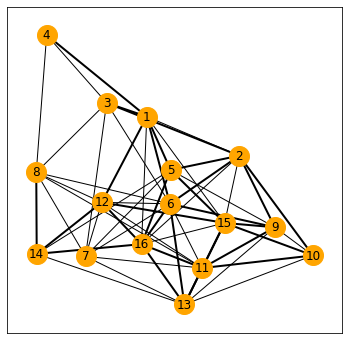

In [5]:
%matplotlib inline
plt.figure(figsize=(6,6))
G = nx.read_edgelist(path="/content/gdrive/My Drive/DS420/undirected_weighted.edgelist", delimiter=' ', nodetype=int, data=(('weight',float),))
pos = nx.fruchterman_reingold_layout(G)
edges = []
weights = []
for (source, target, weight) in G.edges.data('weight'):
    edges.append((source, target))
    weights.append(weight)
nx.draw_networkx_nodes(G, pos, node_size=400, node_color='orange')
nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights*32)
nx.draw_networkx_labels(G, pos, font_size=12)
plt.show()

You should see the visualization of the graph. The thicker the edge, the larger the weight. The weight plays an important role in eigenvector centrality.

# 2. Power Iteration for Eigenvector Centrality
We will implement power iteration for eigenvector centrality. In eigenvector centrality, a node aggregate its neighbors' centralities as </br>
\begin{equation}
C_e(v_i) = \frac{1}{\lambda}\sum_{v_j \in \mathcal{N}^{in}(v_i)} A_{ji} C_e(v_j)
\end{equation}
where $\mathcal{N}^{in}(v_i)$ denotes the set of nodes that have incoming links to node $v_i$. It is a recursive definition as the calcualtion of $C_e(v_i)$ depends on $C_e(v_j)$, and the calcualtion of  $C_e(v_j)$ depends on $C_e(v_i)$. We will use power iteration to learn the eigenvector centralities. The basic idea of power iteration is that every node starts with the same score, then each node gives away its score to its successors. We iteratively update the score until convergence. The pseduo code is given below

**Power Iteration**</br>
1. Initialization: set $C_e(v_1), C_e(v_2), \dots, C_e(v_N)$ to 1
2. Update $C_e(v_1), C_e(v_2), \dots, C_e(v_n)$ based on the equation
\begin{equation}
C_e(v_i) \leftarrow \sum_{v_j \in \mathcal{N}^{in}(v_i)} A_{ji} C_e(v_j)
\end{equation}
3. Normalize each term as 
\begin{equation}
C_e(v_i) \leftarrow \frac{C_e(v_i)}{\sqrt{\sum_{j=1}^N C_e(v_j)^2}}
\end{equation}
4. Repeat 2 and 3 until convergence

## 2.1 Basic Operations
Before we implement the power iteration. Let's first introduce some basic operations

In [6]:
# Get nodes of a Graph: G.nodes
G.nodes

NodeView((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16))

In [7]:
# Get neighbor of node 1： G.neighbors(1)
current_node = 1
list(G.neighbors(current_node))

[2, 3, 4, 5, 6, 12, 15, 16]

In [8]:
# Get weights of edges connecting to node 1
for neighbor in G.neighbors(current_node):
    print(G.get_edge_data(neighbor, current_node)['weight'])

1.0
2.0
2.0
2.0
2.0
2.0
1.0
1.0


In [9]:
# With the above operations, we can update the eigenvector centrality of a node as follows
Ce = {node:1.0 for node in G.nodes} # create a dictionary with key as the nodes and values are 1
new_score = 0
for neighbor in G.neighbors(current_node):
    new_score += Ce[neighbor] * G.get_edge_data(neighbor, current_node)['weight'] # aggregate the neighbors' centralities
print(new_score)

13.0


In [10]:
# If you are familar with Python, the above code can also be written as
Ce = {node:1.0 for node in G.nodes} # create a dictionary with key as the nodes and values are 1
new_score = sum(Ce[neighbor] * G.get_edge_data(neighbor, current_node)['weight'] for neighbor in G.neighbors(current_node))
print(new_score)

13.0


## 2.2 Implementing Power Iteration
With the basic operations above, we can implement power iterations. Note we use **maxiter** to control the iterations as we want to show how the eigenvector centralarity changes.

In [11]:
# create a dictionary with key as the nodes and values are 1
Ce = {node:1.0 for node in G.nodes}
maxiter = 10
Ce_record = np.ones((len(G), maxiter+1)) # we use this to record how Ce changes
Ce_tmp = {node:0.0 for node in G.nodes}  # this is used to store the intermediate value of Ce

In [21]:
# main loop
for i in range(0, maxiter):
    
    # for each node, calculate their new eigenvector score and put in Ce_tmp
    for current_node in Ce.keys():
        # aggregate the centrality score from connected neighbors
        Ce_tmp[current_node] = sum(Ce[neighbor] * G.get_edge_data(neighbor, current_node)['weight'] for neighbor in G.neighbors(current_node))

        """
        # If you are not familar with Python, the above line is equivalent to the following
        tmp = 0
        for neighbor in G.neighbors(current_node):
          tmp += Ce[neighbor] * G.get_edge_data(neighbor, current_node)['weight']
        Ce_tmp[current_node] = tmp
        """

    # normalization
    normalization_term = sum(Ce_tmp[node]**2 for node in Ce_tmp) ** 0.5
    for node in Ce:
        Ce[node] = Ce_tmp[node] / normalization_term

    # record the values
    for node,j in zip(Ce, range(0, len(G))):
        Ce_record[j,i+1] = Ce[node]


eigenvector centralities: {1: 0.2559301168406317, 2: 0.2786619503569094, 3: 0.14526481888950304, 4: 0.06613518340550696, 5: 0.25240924819133903, 6: 0.32369757710133484, 7: 0.14363114951401926, 8: 0.13312674243832168, 9: 0.27218106256721175, 10: 0.2026929331579325, 11: 0.31362701590255976, 12: 0.2615611285516877, 13: 0.28656747896107726, 14: 0.1684097906306847, 15: 0.339329505540746, 16: 0.3419912279795041}


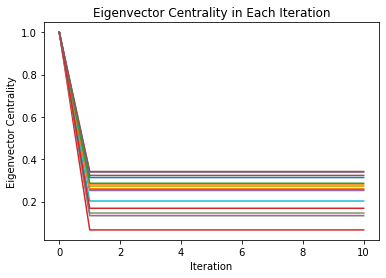

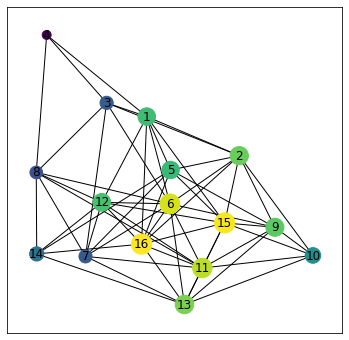

In [22]:
# results
print('eigenvector centralities: {}'.format(Ce))

# visualize how the centrality changes
plt.figure()
plt.plot(np.transpose(Ce_record))
plt.title('Eigenvector Centrality in Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('Eigenvector Centrality')
plt.show()

# visualiz the graph with node size reflecting the centrality
plt.figure(figsize=(6,6))
nodesize = [Ce[node]*1200 for node in Ce]
nx.draw_networkx(G, pos, with_labels=True, node_size=nodesize, font_size=12, node_color=nodesize)
plt.show()

From the above visualization, we can observe that after 3 iterations, the algorithm converges.

## <font color='green'>Exercise 1: Power Iteration for Katz Centraltiy</font>
Following the above example, please implement power iteration for Katz Centrality. The equation for Katz centrality is 
\begin{equation}
C_k(v_i) = \alpha\sum_{v_j \in \mathcal{N}^{in}(v_i)} A_{ji} C_k(v_j) + \beta
\end{equation}
Please set $\alpha=0.85$, $\beta=0.15$

**Power Iteration**</br>
1. Initialization: set $C_k(v_1), C_k(v_2), \dots, C_k(v_N)$ to 1
2. Update $C_k(v_1), C_k(v_2), \dots, C_k(v_n)$ based on the equation
\begin{equation}
C_k(v_i) \leftarrow \sum_{v_j \in \mathcal{N}^{in}(v_i)} A_{ji} C_k(v_j) + \frac{\beta}{\alpha}
\end{equation}
3. Normalize each term as 
\begin{equation}
C_k(v_i) \leftarrow \frac{C_k(v_i)}{\sqrt{\sum_{j=1}^N C_k(v_j)^2}}
\end{equation}
4. Repeat 2 and 3 until convergence

In [14]:
# TODO
# Hint: the only difference with eigenvector centrality is in step 2, we need to add beta/alpha
alpha = 0.85
beta = 0.15

# Your code here:  ????????????????????

## 2.3 Vectorization
The equation for eigenvector centrality can be vectrozied as
\begin{equation}
\mathbf{c} = \frac{1}{\lambda}\mathbf{A}^T \mathbf{c}
\end{equation}
Where $\mathbf{c}$ is a vector of size $N$ with the $i$-th element as the eigenvector centrality of the $i$-th node in the graph. With the vectorized version, the implementation is much easier.

**Power Iteration**</br>
1. Initialization: set **c** to all one vector
2. Update **c** based on the equation
\begin{equation}
\mathbf{c} \leftarrow \mathbf{A}^T \mathbf{c}
\end{equation}
3. Normalize each term as 
\begin{equation}
\mathbf{c} \leftarrow \frac{\mathbf{c}}{\|\mathbf{c}\|_2}
\end{equation}
4. Repeat 2 and 3 until convergence

### basic operations
We will first introduce some basice operations

[[0. 1. 2. 2. 2. 2. 0. 0. 0. 0. 0. 2. 0. 0. 1. 1.]
 [1. 0. 2. 0. 2. 2. 0. 0. 2. 2. 0. 0. 0. 0. 1. 1.]
 [2. 2. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 2. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 2. 2.]
 [2. 2. 1. 0. 0. 0. 1. 1. 2. 0. 1. 1. 2. 0. 0. 2.]
 [0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 2. 0. 0.]
 [0. 2. 0. 0. 1. 2. 0. 0. 0. 1. 2. 0. 1. 0. 2. 0.]
 [0. 2. 0. 0. 0. 0. 0. 0. 1. 0. 2. 0. 1. 0. 2. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 2. 2. 0. 1. 2. 0. 2. 2.]
 [2. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 2. 2. 2.]
 [0. 0. 0. 0. 0. 2. 1. 0. 1. 1. 2. 0. 0. 1. 2. 2.]
 [0. 0. 0. 0. 1. 0. 0. 2. 0. 0. 0. 2. 1. 0. 0. 2.]
 [1. 1. 0. 0. 2. 0. 0. 0. 2. 2. 2. 2. 2. 0. 0. 1.]
 [1. 1. 0. 0. 2. 2. 0. 0. 0. 0. 2. 2. 2. 2. 1. 0.]]


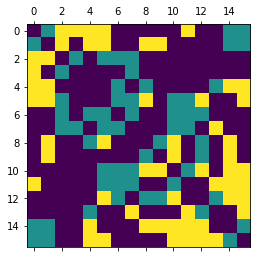

In [23]:
# we can use nx.adjacency_matrix(G) to get the adjacency matrix of G
A = nx.adjacency_matrix(G).todense()
print(A)
plt.matshow(A)

The visualization of the adjency matrix has 3 colors, which represent there weights, yellow: 2, green: 1 and blue: 0

In [24]:
# create a vector of size (A.shape[0], 1)
c = np.ones((A.shape[0], 1))
print(c)

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [25]:
# update the the centrality score with the equation
c = np.dot(np.transpose(A), c)  # A^T c
print(c)

[[13.]
 [13.]
 [ 8.]
 [ 4.]
 [11.]
 [15.]
 [ 7.]
 [ 8.]
 [11.]
 [ 8.]
 [14.]
 [12.]
 [12.]
 [ 8.]
 [15.]
 [15.]]


In [26]:
# normalization
c = c / np.linalg.norm(c)
print(c)

[[0.28642422]
 [0.28642422]
 [0.17626106]
 [0.08813053]
 [0.24235896]
 [0.33048949]
 [0.15422843]
 [0.17626106]
 [0.24235896]
 [0.17626106]
 [0.30845685]
 [0.26439159]
 [0.26439159]
 [0.17626106]
 [0.33048949]
 [0.33048949]]


### With these operations, we can now implemnt the power iteration for eigenvector centrality

In [27]:
# initialization
c = np.ones((A.shape[0], 1))

# main loop
maxiter = 10
record_c = np.ones((A.shape[0], maxiter+1))
record_c[:, i] = np.squeeze(c, axis=1)
for i in range(1, maxiter+1):
    c = np.dot(np.transpose(A), c) # c = A^T c
    c = c / np.linalg.norm(c)
    record_c[:,i] = np.squeeze(c, axis=1)

eigenvector centralities: [[0.2559327 ]
 [0.27865895]
 [0.14527372]
 [0.06614117]
 [0.25241708]
 [0.32370061]
 [0.14362957]
 [0.1331308 ]
 [0.27217739]
 [0.20269006]
 [0.31362083]
 [0.26157012]
 [0.28656625]
 [0.16840959]
 [0.33932053]
 [0.3419907 ]]


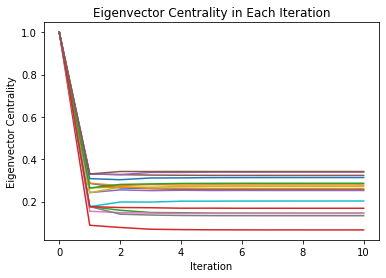

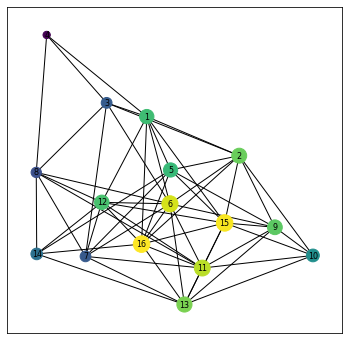

In [28]:
# results
print('eigenvector centralities: {}'.format(c))

# visualize how the centrality changes
plt.figure()
plt.plot(np.transpose(record_c))
plt.title('Eigenvector Centrality in Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('Eigenvector Centrality')
plt.show()

# visualiz the graph with node size reflecting the centrality
plt.figure(figsize=(6,6))
nx.draw_networkx(G, pos, with_labels=True, node_size=list(c*800), font_size=8, node_color=nodesize)
plt.show()

## <font color='green'>Exercise 2: Vectorized Version for Katz Centrality</font>
Following the above example, please implement the vectorized version for Katz Centrality. The vectorized equation for Katz centrality is
\begin{equation}
\mathbf{c} = \alpha \mathbf{A}^T \mathbf{c} + \beta \mathbf{1}
\end{equation}
where $\mathbf{c}$ is a vector of size $N$ with the $i$-th element as the Katz centrality of the $i$-th node in the graph. $\mathbf{1}$ is an all one vector. We have provided the code to get the all one vector below.

In [29]:
# TODO
alpha = 0.85
beta = 0.15
all_one_vector = np.ones((A.shape[0], 1))

## 2.4 Eigendecomposition for eigenvector centrality
Eigenvector centrality is called "eigenvector" becasue the scores are actually the eigenvector of the largest eigenvalues of the adjacency matrix. Next we will show how to use eigendecomposition to get the centrality score

In [30]:
# eigen decomposition of A
eigenValues, eigenVectors = np.linalg.eigh(A)

# sort the eigenvalues from largest to smallest
idx = eigenValues.argsort()[::-1]
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]
print(eigenValues)

[11.94903763  4.71745713  4.00945036  2.34246659  1.29210882  0.84385161
  0.26388917 -0.3047154  -0.56103915 -1.69079368 -2.00184459 -2.53573353
 -3.11296371 -4.60215813 -5.07836522 -5.53064788]


In [31]:
# The eigenvector centrality is obtained as the eigenvector corresponding to the largest eigenvalue
c_eig = np.transpose(np.squeeze(eigenVectors[:,0], axis=1))
print(c_eig)

[[0.25593012]
 [0.27866195]
 [0.14526482]
 [0.06613518]
 [0.25240925]
 [0.32369758]
 [0.14363115]
 [0.13312674]
 [0.27218106]
 [0.20269293]
 [0.31362702]
 [0.26156113]
 [0.28656748]
 [0.16840979]
 [0.33932951]
 [0.34199123]]


## <font color='green'>Exercise 3: Verify that c_eig and c we get in 2.2 are the same</font>
To verify this, please calculate the l2 distance of c_eig and c, i.e.
\begin{equation}
    \|c\_eig - c\|_2 = \sqrt{\sum_{i} (c(i) - c\_eig(i))^2}
\end{equation}
**Hint**: You can do this by calling np.linalg.norm(c - c_eig). Please make sure that c is the eigenvector centrality. You might have reused c for katz centrality.

In [ ]:
# TODO: Please calcula

Question: Are c_eig and c the same? Why?

Answer: ????????????????????

# 3. Link Prediction
In this part, we will implement the Jaccard Similairy and Cossine for Link Prediction

## 3.1 Basic Operations

In [32]:
# get neighbors of node u and v
u = 1 # assume u is node 1
v = 2 # assume v is node 2
u_neighbors = set(G.neighbors(u))
v_neighbors = set(G.neighbors(v))
print(u_neighbors)
print(v_neighbors)

{2, 3, 4, 5, 6, 12, 15, 16}
{1, 3, 5, 6, 9, 10, 15, 16}


In [33]:
# union of two sets
unique_friends = u_neighbors.union(v_neighbors)
print(unique_friends)

# intersect of 
common_friends = u_neighbors.intersection(v_neighbors)
print(common_friends)

{1, 2, 3, 4, 5, 6, 9, 10, 12, 15, 16}
{3, 5, 6, 15, 16}


In [34]:
# number of common_friends
len(common_friends)
print(len(common_friends))

# number of unique_friends
len(unique_friends)
print(len(unique_friends))

5
11


## <font color='green'>Exercise 4: Jaccard Similarity of Two nodes</font>
The jaccard simialrity of two nodes u and v is defined as
\begin{equation}
jaccard\_simialrity(u,v) = \frac{\Big| u\_neighbors \cap v\_neighbors \Big|}{\Big| u\_neighbors \cup v\_neighbors \Big|}=\frac{\# \text{ of common friends of u and v}}{\# \text{ of unique friends of u and v}}
\end{equation}
With the definiton and above code please finish the following code

In [ ]:
# TODO: Please calculate the jaccard similarity of node u and v, and return the score
def jaccard_similarity(G, u, v):
    """
    This function calculate the jaccard similarity of two nodes u and v based on the graph structure G
    :param G: the networkx graph
    :param u: node
    :param v: node
    :return: a scalar, the jaccard simialrity of node u and v
    """
    if u not in G.nodes or v not in G.nodes:
        raise ValueError
    u_neighbors = set(G.neighbors(u))
    v_neighbors = set(G.neighbors(v))
    
    ## plese calculate the jaccard simialrity ??????????????????????
    
    # return the similarity
    return  ??????????

    

In [ ]:
# call your function to calculate the jaccard similarity of node 1 and 2
# if you see 0.45454545454545453, then you answer is correct
similarity = jaccard_similarity(G, 1, 2)
print(similarity)
if similarity == 0.45454545454545453:
    print('Correct!')
else:
    print('Incorrect')

0.45454545454545453
Correct!


## <font color='green'>Exercise 5: Cosine </font>
The cosine simialrity of two nodes u and v is defined as
\begin{equation}
jaccard\_simialrity(u,v) = \frac{\Big|u\_neighbors \cap v\_neighbors \Big|}{\sqrt{|u\_neighbors| \times |v\_neighbors|}}=\frac{\#\text{ of common friends of u and v}}{\sqrt{|u\_neighbors| \times |v\_neighbors|}}
\end{equation}
With the definiton and above code please finish the following code

In [ ]:
# TODO: Please calculate the cosine similarity of node u and v, and return the score
def cosine_similarity(G, u, v):
    """
    This function calculate the cosine similarity of two nodes u and v based on the graph structure G
    :param G: the networkx graph
    :param u: node
    :param v: node
    :return: a scalar, the cosine simialrity of node u and v
    """
    if u not in G.nodes or v not in G.nodes:
        raise ValueError
    u_neighbors = set(G.neighbors(u))
    v_neighbors = set(G.neighbors(v))
    ## plese calculate the cosine simialrity ??????????????????????
    
    # return the cosine similarity
    return ???????????????
    

In [ ]:
# call your function to calculate the cosine similarity of node 1 and 2
similarity = cosine_similarity(G, 1, 2)
print(similarity)
if similarity == 0.625:
    print('Correct!')
else:
    print('Incorrect')

0.625
Correct!


## <font color='green'>Exercise 6: Link Prediction Example</font>
Use jaccard simialrity to recommend top 2 users to node 1

In [ ]:
# TODO: 
user = 1 # the user we want to suggest friends
# the set of nodes that are not linked with the user
preds = []
for node in G.nodes:
    if node not in G.neighbors(user) and node != user:
        # call your function to calculate the jaccard similarity of user and node
        similarity = ???????????????
        # store the simialrity to preds
        preds.append((user, node, similarity))
        

# rank based on the jaccard similarity
ranked = sorted(preds, key=lambda x: x[2], reverse=True)
print(ranked)

Question: Which two nodes should we recommende to node 1? Why?

Answer: ?????????????

# 4. Regular Equivalence (Opitional)

We will implement the regular equivalence. The basic idea of the (simplified) regular equivalence is $v_i$ and $v_j$ are simialr if $v_j$ is simialr to $v_i$'s neighor $v_k$. This can be mathmatically written as
\begin{equation}
\sigma_r(v_i,v_j) = \alpha \sum_{v_k \in \mathcal{N}(v_i)} A_{ik} \cdot \sigma_r(v_k,v_j)
\end{equation}
where $\sigma_r(v_i,v_j)$ denotes the regular equivalence between $v_i$ and $v_j$ and $\alpha$ is a scalar to make the equality hold. To solve the above equation, we will first vectorize it. Let $\sigma_r$ be an $n \times n$ matrix with its $(i,j)$-th element as the regular equivlance between $v_i$ and $v_j$. Then the above equation can be written as
\begin{equation}
\mathbf{\sigma}_r = \alpha\cdot \mathbf{A} \cdot \mathbf{\sigma}_r
\end{equation}
To guarantee that a node is highly similar to itself, we add the identity matrix to the above equation as
\begin{equation}
\mathbf{\sigma}_r = \alpha\cdot \mathbf{A} \cdot \mathbf{\sigma}_r + \mathbf{I}
\end{equation}
where $\mathbf{I}$ is an $n \times n$ identity matrix. With the above equation,we can get
\begin{equation}
\sigma_r = (\mathbf{I} -\alpha \cdot \mathbf{A})^{-1}
\end{equation}
To make sure that the inverse of $\mathbf{I} -\alpha \cdot \mathbf{A}$ exist, we will set $\alpha < \frac{1}{\lambda_{max}}$, where $\lambda_{max}$ is the largest eigenvalue of $\mathbf{A}$.

In [ ]:
# obtain adjacency matrix
A = nx.adjacency_matrix(G).todense()

In [39]:
# eigen decomposition of A
eigenValues, eigenVectors = np.linalg.eigh(A)

# sort the eigenvalues from largest to smallest
idx = eigenValues.argsort()[::-1]
eigenValues = eigenValues[idx]

print(eigenValues)

[11.94903763  4.71745713  4.00945036  2.34246659  1.29210882  0.84385161
  0.26388917 -0.3047154  -0.56103915 -1.69079368 -2.00184459 -2.53573353
 -3.11296371 -4.60215813 -5.07836522 -5.53064788]


In [40]:
1/eigenValues[0]

0.08368874809618261

[[1.09178426 0.12259656 0.13954241 0.11806138 0.15336073 0.16748523
  0.03842339 0.0381166  0.05919804 0.03594417 0.05994796 0.15355166
  0.05646318 0.04265995 0.11906658 0.13001924]
 [0.12259656 1.09710873 0.13491854 0.0204229  0.15972124 0.17496782
  0.03522307 0.0283464  0.16722802 0.14295864 0.07884175 0.05738597
  0.0702796  0.03258402 0.13488216 0.12510741]
 [0.13954241 0.13491854 1.04274909 0.06954753 0.04103331 0.10004012
  0.06735558 0.06911673 0.03457161 0.02309001 0.02978344 0.03666474
  0.02772407 0.018097   0.03505026 0.04080983]
 [0.11806138 0.0204229  0.06954753 1.01823337 0.01867207 0.02599574
  0.01075586 0.05899711 0.00897908 0.00561415 0.01148818 0.02156382
  0.00885274 0.01117884 0.01531447 0.01746508]
 [0.15336073 0.15972124 0.04103331 0.01867207 1.07793653 0.07892614
  0.07121743 0.02568666 0.10685526 0.04800818 0.06767153 0.06940602
  0.0636885  0.08340334 0.16741711 0.16812816]
 [0.16748523 0.17496782 0.10004012 0.02599574 0.07892614 1.11432029
  0.09067608 0.08

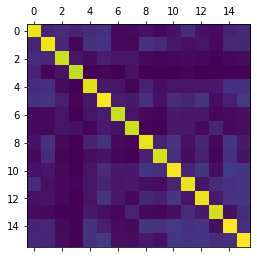

In [44]:
# set alpha smaller than 1/lambda_max
alpha= 0.05
P = np.linalg.pinv(np.identity(A.shape[0]) - alpha*A) # (I - alpha* A)^-1
print(P)
plt.matshow(P)

## <font color='green'>Exercise 7 (Optional)</font>
Run experiments $\alpha > \frac{1}{\lambda_{max}}$. Does the results make sense? Why?

In [45]:
alpha= 0.1
P = np.linalg.pinv(np.identity(A.shape[0]) - alpha*A) # (I - alpha* A)^-1
print(P)

[[ 0.67080877 -0.38041017 -0.01823044  0.11119249 -0.27295287 -0.41668453
  -0.24614737 -0.21146217 -0.53600091 -0.43542619 -0.65276345 -0.30091541
  -0.58846481 -0.29553651 -0.58172448 -0.5345961 ]
 [-0.38041017  0.54850122 -0.08474895 -0.11431396 -0.31636002 -0.47316394
  -0.29862343 -0.29757028 -0.34624185 -0.23145204 -0.64520192 -0.57239259
  -0.5967966  -0.39362898 -0.58904027 -0.64160373]
 [-0.01823044 -0.08474895  0.96010513  0.08982834 -0.23255563 -0.20561043
  -0.05184699 -0.02536082 -0.3008591  -0.24233397 -0.3921361  -0.26716959
  -0.35574245 -0.1933893  -0.40648401 -0.38026704]
 [ 0.11119249 -0.11431396  0.08982834  1.03627733 -0.1040244  -0.12605535
  -0.05625558  0.05055995 -0.16749827 -0.13512235 -0.19344037 -0.09861247
  -0.18081148 -0.07307118 -0.19370256 -0.17488545]
 [-0.27295287 -0.31636002 -0.23255563 -0.1040244   0.61341093 -0.57660665
  -0.20451684 -0.2617826  -0.41979061 -0.37071766 -0.59897526 -0.44774459
  -0.54091464 -0.22670134 -0.45790042 -0.46022764]
 [-0.

Your Answer Here: ????????????????

## <font color='green'>Exercise 8 Approximating $(\mathbf{I} - \alpha \cdot \mathbf{A})^{-1}$ (Optional)</font>

In the class, we showed that $(\mathbf{I} - \alpha \cdot \mathbf{A})^{-1}=\sum_{k=0}^{\infty} \alpha^k \mathbf{A}^k$. Thus, we can approximate $(\mathbf{I} - \alpha \cdot \mathbf{A})^{-1}$ as $(\mathbf{I} - \alpha \cdot \mathbf{A})^{-1}=\sum_{k=0}^{K} \alpha^k \mathbf{A}^k$, where $K$ is a large number. Please understand the code below, explore the results of different choices of $K$ and compare with $\mathbf{P}$ calculated directly using $(\mathbf{I} - \alpha \cdot \mathbf{A})^{-1}$

In [50]:
Pa = 0
K = 10
alpha = 0.05
tmp = np.eye(A.shape[0])
for i in range(0,K):
  Pa = Pa + tmp
  tmp = tmp * alpha * A
print(Pa)

[[1.09084091 0.12156976 0.1390073  0.11781775 0.15243119 0.16629291
  0.037894   0.03762596 0.05819525 0.03519761 0.05879272 0.15258827
  0.05540757 0.04203941 0.11781638 0.12875904]
 [0.12156976 1.09599074 0.13433592 0.02015764 0.15870891 0.17366946
  0.03464684 0.02781237 0.16613621 0.14214567 0.07758366 0.05633689
  0.06913011 0.03190844 0.13352093 0.12373555]
 [0.1390073  0.13433592 1.04244513 0.06940911 0.04050526 0.0993631
  0.06705532 0.06883833 0.03400253 0.02266616 0.02912769 0.0361176
  0.02712486 0.01774487 0.03434085 0.04009479]
 [0.11781775 0.02015764 0.06940911 1.0181703  0.01843163 0.02568745
  0.01061917 0.05887037 0.00872007 0.00542123 0.01118962 0.0213147
  0.00857998 0.01101847 0.01499151 0.01713959]
 [0.15243119 0.15870891 0.04050526 0.01843163 1.07701891 0.07774976
  0.07069582 0.02520304 0.10586643 0.04727161 0.06653192 0.06845525
  0.06264715 0.08279154 0.16618446 0.16688586]
 [0.16629291 0.17366946 0.0993631  0.02568745 0.07774976 1.11281166
  0.09000692 0.08428